# Dealing with uncertainty using heteroscedastic dropout

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from functools import partial
from scipy import stats, interpolate
from src.data import generate_dataset, generate_sin_shaped_dataset
from src.visualization import beautify_ax

%load_ext autoreload
%autoreload 2

# Generating data
Generating a dataset with a increasing variance. This allows to demonstrate differences in uncertainty, which should be higher when x increases.

In [2]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

## Plotting the data

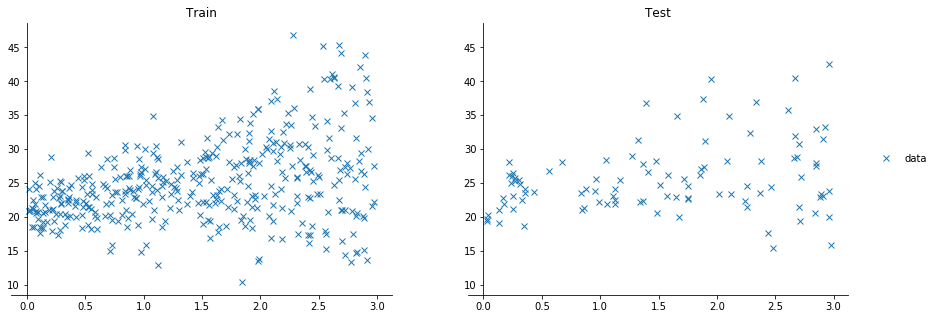

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Now let's try something more difficult!

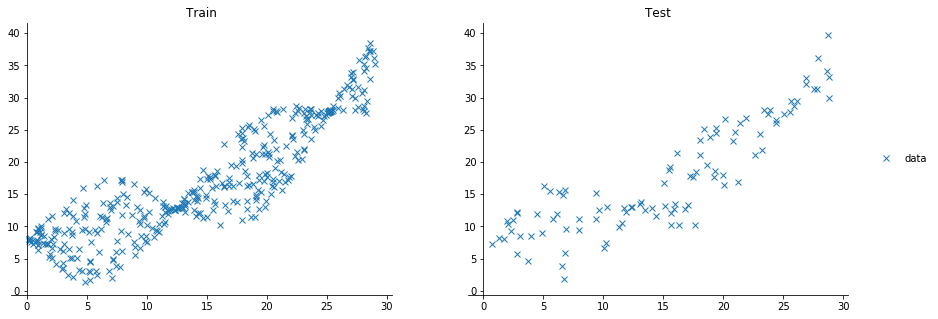

In [6]:
x, x_test, y, y_test = generate_sin_shaped_dataset(n=500, test_size=.2)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data
To make sure the feature $x$ and target $y$ are in the same scale

In [7]:
mmsx = MinMaxScaler().fit(x)
x, x_test = mmsx.transform(x), mmsx.transform(x_test)

mmsy = MinMaxScaler().fit(y)
y, y_test = mmsy.transform(y), mmsy.transform(y_test)

In [8]:
class HeteroscedasticDropoutNet(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
            nn.PReLU(),
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['hidden_size']),
            nn.PReLU(),
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['output_size'])
        )
        self.optim = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr']
        )
    
    def forward(self, X):
        return self.model_(X)
    
    def mc_predict(self, X, samples=4000):
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1)
        return preds
    
    def save(self, path, fname):
        torch.save({
            "model_state_dict": self.model_.state_dict(),
            "optim_state_dict": self.optim_.state_dict(),
        }, os.path.join(path, fname))
    
    def load(self, path, fname):
        checkpoint = torch.load(os.path.join(path, fname))
        self.model_.load_state_dict(checkpoint['model_state_dict'])
        self.optim_.load_state_dict(checkpoint['optim_state_dict'])
        return self

## Loss and utility functions
- Created a quantile loss function that calculates the loss for all quantiles. 
- A functions that helps creating (evenly spaced) array of 'quantiles'. 

In [9]:
def log_gaussian_loss(output, target, sigma, no_dim):
#     # the manual way:
    # sigma = torch.cat([sigma, torch.zeros_like(sigma)], dim=1).max(dim=1).values - 1 + 1e-6
    sigma = torch.exp(sigma)
#     sigma = torch.nn.functional.softplus(sigma)
    exp = -((target - output)**2) / (2 * sigma**2)
    log_coef = -torch.log(sigma)
    const = -0.5*np.log(2*np.pi)
    loss = -(exp + log_coef + const).sum()
    
    # the automagic way
    dist = torch.distributions.normal.Normal(output, sigma)
    loss = -dist.log_prob(target).sum()
    # in case you want to parameterize a different distribution
    
    return loss

## Model setup
Predicting for multiple evenly spaced quantiles with an lower limit of `0.01` and upper limmit of `0.99`. These parameters are selected by trying out some configurations manually. You could of course optimize this. 

In [10]:
params = {
    'input_size': 1,
    'output_size': 2,
    'hidden_size': 256,
    'dropout_p': 0.2,
    'batch_size': 64,
    'epochs': 2001,
    'lr': 1e-3,
}
model = HeteroscedasticDropoutNet(params)
criterion = partial(log_gaussian_loss, no_dim=1)

## Training the model

In [11]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

In [12]:
model.optim.state_dict()['param_groups'][0]['lr'] = 1e-4

In [13]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        output = model(x_batch)
        loss = criterion(output[:, :1], y_batch, output[:, 1:])
        loss.backward()
        model.optim.step()
        model.optim.zero_grad()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            output_train = model(x_train)
            mean_train = mean_absolute_error(y_train, output_train[:, :1])
            train_loss = criterion(output_train[:, :1], y_train, output_train[:, 1:])
            output_val = model(x_val)
            mean_val = mean_absolute_error(y_val, output_val[:, :1])
            val_loss = criterion(output_val[:, :1], y_val, output_val[:, 1:])
    
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f} \t MAE train: {mean_train:.5f} \t MAE val: {mean_val:.5f}")

Epoch: 0 	 Train loss:-130.35519 	 Val loss: -34.22189 	 MAE train: 0.14181 	 MAE val: 0.14077
Epoch: 100 	 Train loss:-410.70648 	 Val loss: -99.02951 	 MAE train: 0.06906 	 MAE val: 0.07355
Epoch: 200 	 Train loss:-399.59677 	 Val loss: -92.53749 	 MAE train: 0.07478 	 MAE val: 0.07977
Epoch: 300 	 Train loss:-426.88467 	 Val loss: -99.16986 	 MAE train: 0.07166 	 MAE val: 0.07568
Epoch: 400 	 Train loss:-440.52707 	 Val loss: -104.72269 	 MAE train: 0.06772 	 MAE val: 0.07060
Epoch: 500 	 Train loss:-450.28506 	 Val loss: -105.60681 	 MAE train: 0.06978 	 MAE val: 0.07312
Epoch: 600 	 Train loss:-440.32492 	 Val loss: -102.93745 	 MAE train: 0.07178 	 MAE val: 0.07515
Epoch: 700 	 Train loss:-482.91394 	 Val loss: -112.46462 	 MAE train: 0.06794 	 MAE val: 0.07129
Epoch: 800 	 Train loss:-493.10562 	 Val loss: -112.41042 	 MAE train: 0.06729 	 MAE val: 0.07178
Epoch: 900 	 Train loss:-491.55234 	 Val loss: -113.69606 	 MAE train: 0.06899 	 MAE val: 0.07231
Epoch: 1000 	 Train loss:-

In [36]:
preds_train = model.mc_predict(x_train, samples=4000).numpy()
preds_val = model.mc_predict(x_val, samples=4000).numpy()

si_train = x_train.argsort(dim=0).flatten()
train_x_, train_y_hat = x_train[si_train].numpy(), preds_train[si_train, :, :]
train_y_ = y_train[si_train].numpy()

si_val = x_val.argsort(dim=0).flatten()
val_x_, val_y_hat = x_val[si_val].numpy(), preds_val[si_val, :, :]
val_y_ = y_val[si_val].numpy()

In [41]:
def postprocess_samples(samples):
    mus = np.mean(samples[:, 0, :], axis=-1)
    sigmas = np.mean(np.exp(samples[:, 1, :]), axis=-1)
    return mus, sigmas

In [42]:
pred_mu_train, pred_sigma_train = postprocess_samples(train_y_hat)
pred_mu_val, pred_sigma_val = postprocess_samples(val_y_hat)

In [15]:
# Dealing with the samples
sampled_mus = train_y_hat[:, 0, :]
mean_mus = sampled_mus.mean(axis=-1)
noises = np.exp(train_y_hat[:, 1, :])

# calculating different uncertainties
aleatoric = (noises**2).mean(axis=-1)**0.5
epistemic = (sampled_mus.std(axis=-1))
# total_unc = (aleatoric**2 + epistemic**2)**0.5
# total_unc = aleatoric + epistemic

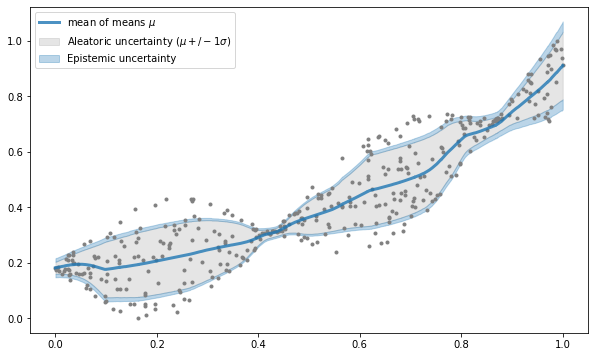

In [16]:
upper_aleatoric = mean_mus + aleatoric
lower_aleatoric = mean_mus - aleatoric
upper_total = upper_aleatoric + epistemic
lower_total = lower_aleatoric - epistemic

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', c='grey', markersize=3)
plt.plot(train_x_, mean_mus, lw=3, color='tab:blue', alpha=.8, label='mean of means $\mu$')
plt.fill_between(train_x_.flatten(), lower_aleatoric, upper_aleatoric, alpha=.2, color='grey', label='Aleatoric uncertainty ($\mu +/- 1\sigma$)')
plt.fill_between(train_x_.flatten(), lower_total, lower_aleatoric, alpha=.3, color='tab:blue', label='Epistemic uncertainty')
plt.fill_between(train_x_.flatten(), upper_aleatoric, upper_total, alpha=.3, color='tab:blue')
plt.legend();

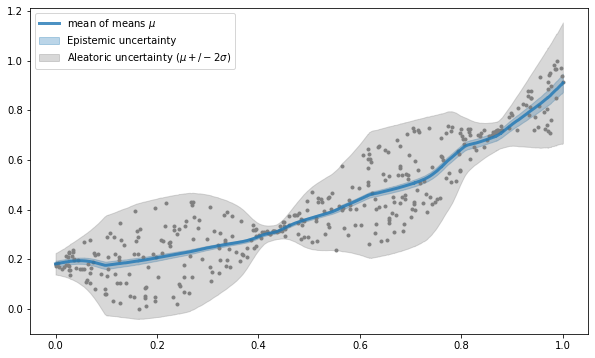

In [18]:
upper_ep = mean_mus + epistemic
lower_ep = mean_mus - epistemic
upper_total = mean_mus + aleatoric*2
lower_total = mean_mus - aleatoric*2

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', c='grey', markersize=3)
plt.plot(train_x_, mean_mus, lw=3, color='tab:blue', alpha=.8, label='mean of means $\mu$')
plt.fill_between(train_x_.flatten(), lower_ep, upper_ep, alpha=.3, color='tab:blue', label='Epistemic uncertainty')
plt.fill_between(train_x_.flatten(), lower_total, upper_total, alpha=.3, color='grey', label='Aleatoric uncertainty ($\mu +/- 2\sigma$)')
# plt.fill_between(train_x_.flatten(), upper_ep, upper_total, alpha=.3, color='grey')
plt.legend();

## Saving model state

In [19]:
# model.save(path='../models/', fname='deep_quantile_regression.pth')

In [20]:
# model = DeepQuantileRegression(params)
# model.load(path='../models/', fname='deep_quantile_regression.pth')

## Plotting the distribution of the parameters

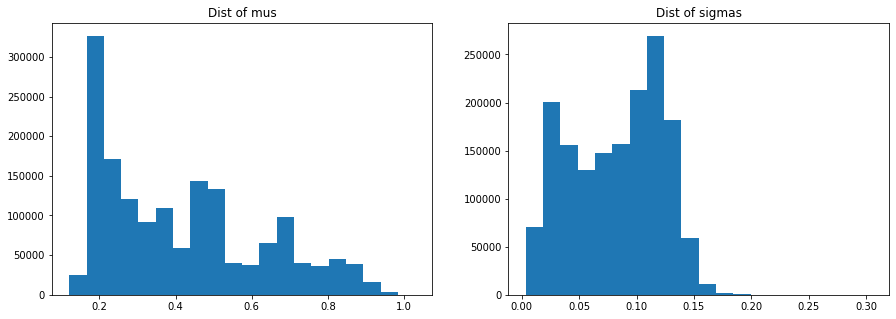

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title("Dist of mus")
axes[0].hist(pred_mu_train.flatten(), bins=20)
axes[1].set_title("Dist of sigmas")
axes[1].hist(pred_sigma_train.flatten(), bins=20);

## Plotting individual predicted probability distributions

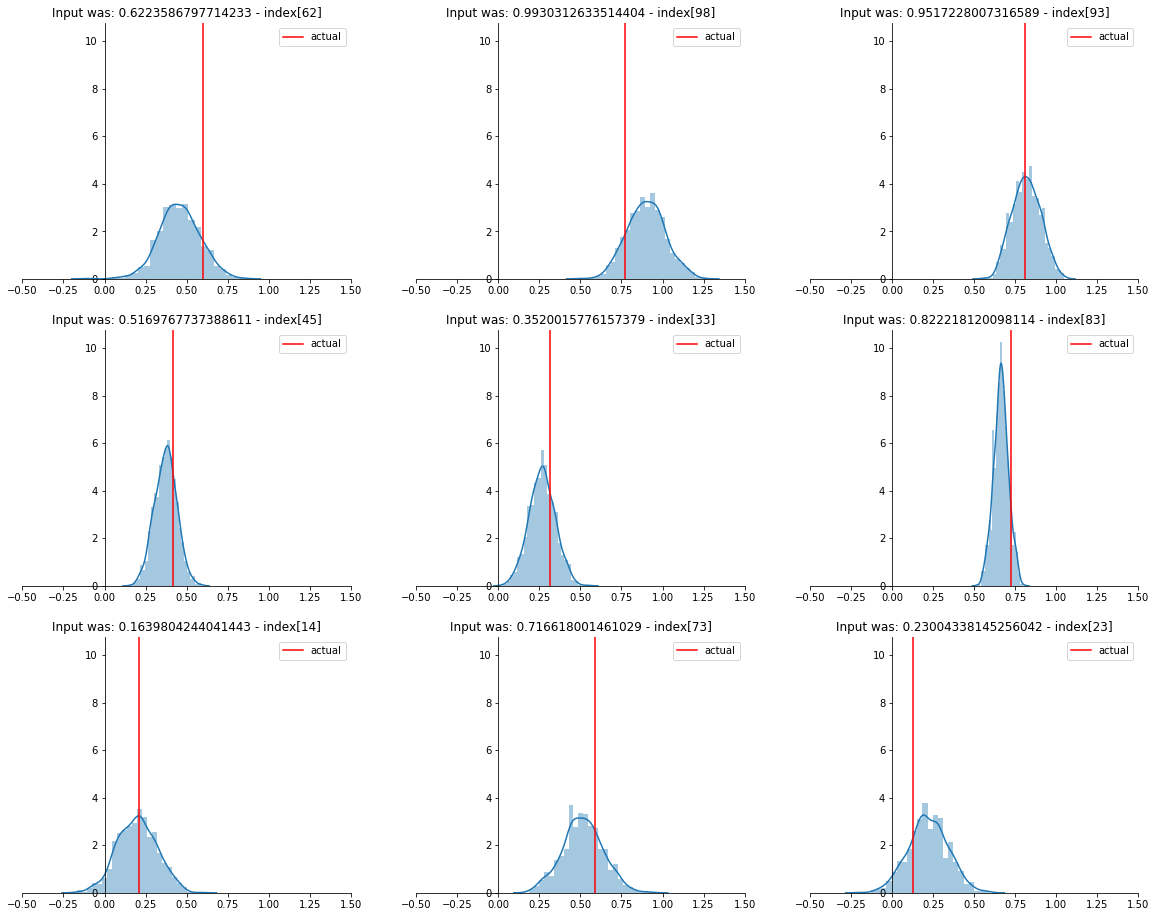

In [48]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
random_is = np.random.randint(low=0, high=x_val.shape[0], size=len(axes.flat))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=pred_mu_val[i], scale=pred_sigma_val[i])
    sns.distplot(pred_norm, bins=25, ax=ax)
    ax.axvline(val_y_[i], c='r', label='actual')
    ax.set_title(f"Input was: {val_x_[i][0]} - index[{i}]")
    ax.set_xlim(-.5, 1.5)
    ax.legend();

## Plotting individual predicted probability distributions (in original data scale)

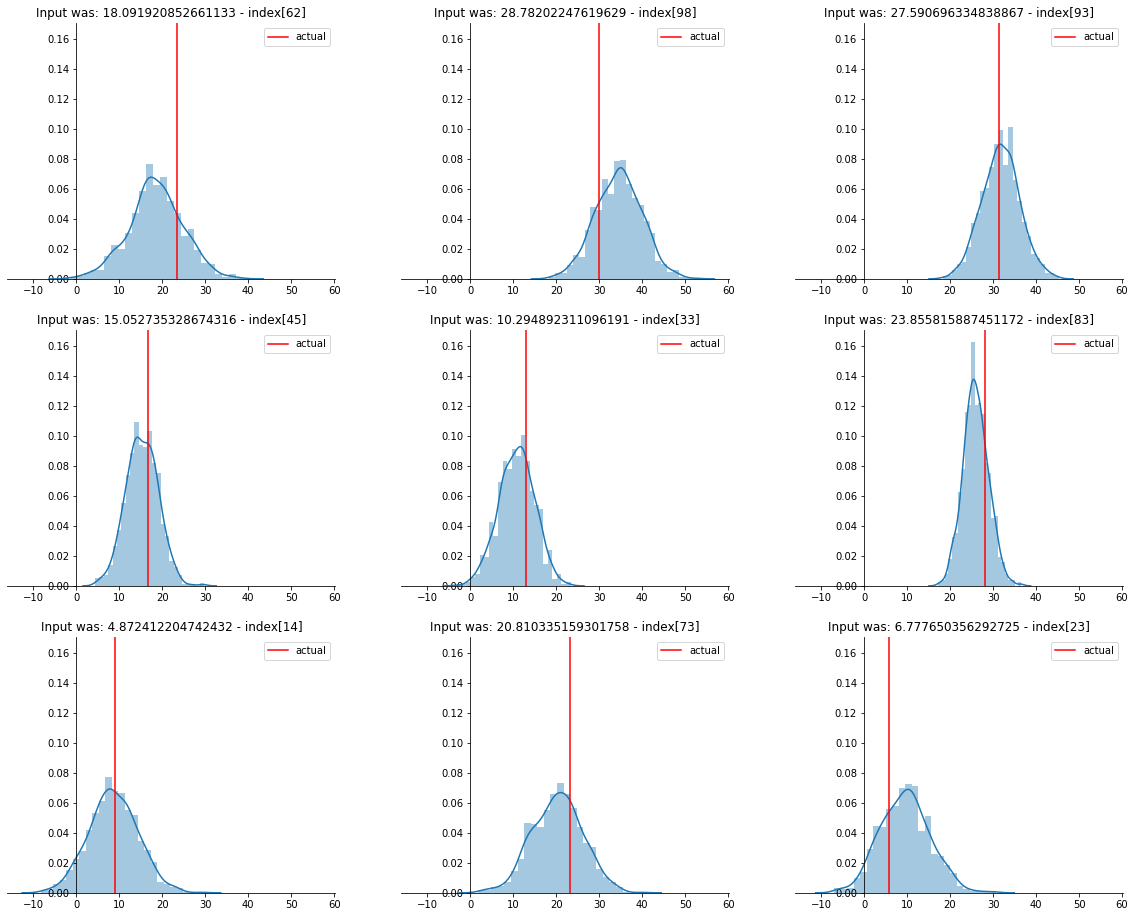

In [49]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
# transform values back to original scale
org_x = mmsx.inverse_transform(val_x_)
org_y = mmsy.inverse_transform(val_y_)  
inv_pred_mu_val = mmsy.inverse_transform(pred_mu_val.reshape(-1,1)).flatten()
inv_pred_sigma_val = mmsy.inverse_transform(pred_sigma_val.reshape(-1,1)).flatten()

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=inv_pred_mu_val[i], scale=inv_pred_sigma_val[i])
    sns.distplot(pred_norm, bins=25, ax=ax)
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i][0]} - index[{i}]")
    ax.legend();